## Imports

In [125]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pickle
import seaborn as sns
import os
import pandas as pd
import muon as mu
import scanpy as sc
import mofax
import anndata as ad
from scipy.stats import pearsonr

## Load data

In [126]:
# Define the data folders.
data_folder = "/users/csb/huizing/Documents/PhD/Code/mowgli_reproducibility/data/"
fig_folder = (
    "/users/csb/huizing/Documents/PhD/Code/mowgli_reproducibility/visualize/figures/"
)
w_folder = "/users/csb/huizing/Documents/PhD/Code/Mowgli/local_analysis/from_jz/w/"

In [127]:
# Load the 10X multiome data: RNA + ATAC.
rna_all_genes = mu.read_10x_h5(
    "/users/csb/huizing/Documents/PhD/Code/"
    + "mowgli_reproducibility/data/TEA/"
    + "GSM4949911_X061-AP0C1W1_leukopak_perm-cells_"
    + "tea_fulldepth_cellranger-arc_filtered_feature_bc_matrix.h5",
    extended=False,
)['rna']

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [128]:
# Compute quality control metrics.
rna_all_genes.var["mt"] = rna_all_genes.var_names.str.startswith("rna:MT-")
sc.pp.calculate_qc_metrics(
    rna_all_genes,
    qc_vars=["mt"],
    percent_top=None,
    log1p=False,
    inplace=True,
)

# Perform per-cell normalization.
sc.pp.normalize_total(rna_all_genes, target_sum=1e4)

# Log-transform the counts.
sc.pp.log1p(rna_all_genes)

In [129]:
# Load the data.
mdata = mu.read_h5mu(data_folder + "TEA/tea_preprocessed.h5mu.gz")

# Load the MOFA model.
mofa_model = mofax.mofa_model(data_folder + "TEA/tea_mofa_15.hdf5")
mdata.obsm["X_mofa"] = mofa_model.get_factors()

# Load the Mowgli model.
mdata.obsm["X_mowgli"] = np.load(
    w_folder + "tea_mowgli_cosine_50_0_05_rna_0_01_atac_0_1_adt_0_01_0_001.npy",
    allow_pickle=True,
).item()["W"]

# This is needed somehow.
mdata.uns = {}

In [130]:
rna_all_genes = rna_all_genes[mdata["rna"].obs_names]
rna_all_genes.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [131]:
# enrichment_file = "fgsea"
enrichment_file = "gprofiler"
# enrichment_file = "enrichr"

if enrichment_file == "fgsea": # Get fgsea results.
    enr = pd.read_csv("/users/csb/huizing/Documents/PhD/Code/mowgli_reproducibility/enrich/fgsea.csv", index_col=0)
    enr.rename(columns={"pathway": "native", "col": "dim", "pval": "p_value"}, inplace=True)
    enr["dim"] = enr["dim"].str.replace("X", "").astype(int)
    # Actually, it should be padj instead of pval, but nothing is significant...

elif enrichment_file == "gprofiler": # Get gprofiler results.
    enr = pd.read_csv("/users/csb/huizing/Documents/PhD/Code/mowgli_reproducibility/enrich/enrichment.csv", index_col=0)
    enr["dim"] = enr["query"].str.split(" ", expand=True)[1].astype(int)

elif enrichment_file == "enrichr": # Get enrichr results.
    enr = pd.read_csv("/users/csb/huizing/Documents/PhD/Code/mowgli_reproducibility/enrich/enrichr.csv", index_col=0)
    enr.rename(columns={"path_name": "native", "adj_p_val": "p_value"}, inplace=True)

enr["name"] = enr["native"]
enr = enr[enr["p_value"] < .05]
enr["minlogp"] = -np.log10(enr["p_value"])

In [132]:
idx_MF = enr["source"] == "GO_Molecular_Function_2021" # Molecular function
idx_CC = enr["source"] == "GO_Cellular_Component_2021" # Cellular component
idx_BP = enr["source"] == "GO_Biological_Process_2021" # Biological process
idx_KEGG = enr["source"] == "KEGG_2021_Human" # KEGG pathways
idx_Reac = enr["source"] == "Reactome_2016" # Reactome pathways
idx_Marker = enr["source"] == "CellMarker_Augmented_2021" # Cell types

In [133]:
h_folder = "/users/csb/huizing/Documents/PhD/Code/Mowgli/local_analysis/from_jz/h/"

# Load MOFA+'s weights.
H_mofa = {
    "H_rna": mofa_model.get_weights("rna"),
    "H_atac": mofa_model.get_weights("atac"),
    "H_adt": mofa_model.get_weights("adt"),
}

# Load Mowgli's weights.
H_mowgli = np.load(
    h_folder + "tea_mowgli_cosine_50_0_05_rna_0_01_atac_0_1_adt_0_01_0_001.npy",
    allow_pickle=True,
).item()

## Annotate Mowgli

In [134]:
# Make an object for the Mowgli embedding.
mowgli_embedding = ad.AnnData(mdata.obsm["X_mowgli"], obs=mdata.obs)
mowgli_embedding.obs[mdata["adt"].var_names] = mdata["adt"].X

# Compute neighbors for Mowgli.
sc.pp.neighbors(mowgli_embedding, n_neighbors=25)

# Compute UMAP for Mowgli
sc.tl.umap(mowgli_embedding)

# Compute Leiden for Mowgli
sc.tl.leiden(mowgli_embedding, resolution=0.2, key_added="leiden")

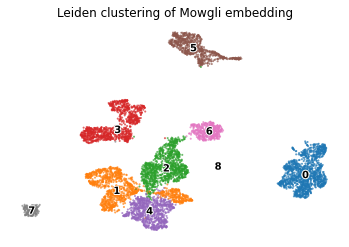

In [135]:
sc.pl.umap(
    mowgli_embedding,
    color="leiden",
    alpha=0.7,
    legend_loc="on data",
    title="Leiden clustering of Mowgli embedding",
    legend_fontoutline=2,
    frameon=False,
)


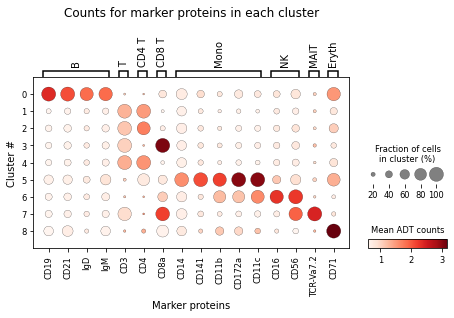

In [136]:
mdata["adt"].obs["leiden_mowgli"] = mowgli_embedding.obs["leiden"]
mdata["adt"].var_names = mdata["adt"].var_names.str.replace("adt:", "")
axes = sc.pl.dotplot(
    mdata["adt"],
    {
        "B": ["CD19", "CD21", "IgD", "IgM"],
        "T": "CD3",
        "CD4 T": "CD4",
        "CD8 T": "CD8a",
        "Mono": ["CD14", "CD141", "CD11b", "CD172a", "CD11c"],
        "NK": ["CD16", "CD56"],
        "MAIT": "TCR-Va7.2",
        "Eryth": "CD71",
    },
    groupby="leiden_mowgli",
    title="Counts for marker proteins in each cluster",
    mean_only_expressed = True,
    colorbar_title = "Mean ADT counts",
    size_title = "Fraction of cells\nin cluster (%)",
    show=False,
    expression_cutoff=.5,
)
axes["mainplot_ax"].set_ylabel("Cluster #")
axes["mainplot_ax"].set_xlabel("Marker proteins")
plt.show()

/users/csb/huizing/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical
/users/csb/huizing/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'genome' as categorical


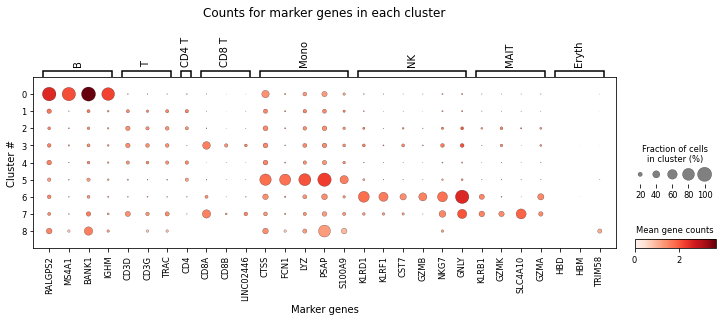

In [137]:
rna_all_genes.obs["leiden_mowgli"] = mowgli_embedding.obs["leiden"]
axes = sc.pl.dotplot(
    rna_all_genes,
    {
        "B": [gene for gene in ["RALGPS2", "MS4A1", "BANK1", "IGHM"] if gene in rna_all_genes.var_names],
        "T": [gene for gene in ["CD3D", "CD3G", "TRAC"] if gene in rna_all_genes.var_names],
        "CD4 T": [gene for gene in ["CD4"] if gene in rna_all_genes.var_names],
        "CD8 T": [gene for gene in ["CD8A", "CD8B", "LINC02446"] if gene in rna_all_genes.var_names],
        "Mono": [gene for gene in ["CTSS", "FCN1", "LYZ", "PSAP", "S100A9"] if gene in rna_all_genes.var_names],
        "NK": [gene for gene in ["KLRD1", "KLRF1", "CST7", "GZMB", "NKG7", "GNLY"] if gene in rna_all_genes.var_names],
        "MAIT": [gene for gene in ["KLRB1", "GZMK", "SLC4A10", "GZMA"] if gene in rna_all_genes.var_names],
        "Eryth": [gene for gene in ["HBD", "HBM", "TRIM58"] if gene in rna_all_genes.var_names],
    },
    groupby="leiden_mowgli",
    title="Counts for marker genes in each cluster",
    mean_only_expressed=True,
    colorbar_title="Mean gene counts",
    size_title="Fraction of cells\nin cluster (%)",
    show=False,
)
axes["mainplot_ax"].set_ylabel("Cluster #")
axes["mainplot_ax"].set_xlabel("Marker genes")
plt.show()


In [138]:
# Annotate the Mowgli embedding.
cluster_names = {
    0: "B cells",
    1: "CD4 T cells",
    2: "CD4 T cells",
    3: "CD8 T cells",
    4: "CD4 T cells",
    5: "Monocytes",
    6: "NK cells",
    7: "MAIT T cells",
    8: "Erythroid cells",
}
mowgli_embedding.obs["leiden"] = [
    cluster_names[c] for c in mowgli_embedding.obs["leiden"].cat.codes
]

/users/csb/huizing/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'leiden' as categorical


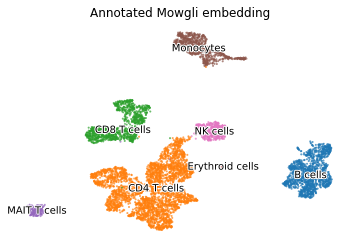

In [139]:
ax = sc.pl.umap(
    mowgli_embedding,
    color="leiden",
    alpha=0.7,
    legend_loc="on data",
    title="Annotated Mowgli embedding",
    legend_fontoutline=2,
    frameon=False,
    legend_fontweight="normal",
    show=False,
)

## Interpret Mowgli's dimensions

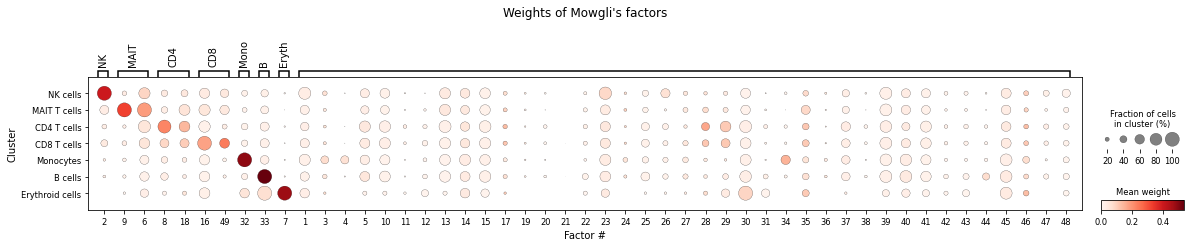

In [187]:
varnames = {
    "NK": ["2"],
    "MAIT": ["9", "6"],
    "CD4": ["8", "18"],
    "CD8": ["16", "49"],
    "Mono": ["32"],
    "B": ["33"],
    "Eryth": ["7"],
    " ": ["1", "3", "4", "5", "10", "11", "12", "13", "14", "15", "17", "19", "20", "21", "22", "23", "24", "25", "26", "27", "28", "29", "30", "31", "34", "35", "36", "37", "38", "39", "40", "41", "42", "43", "44", "45", "46", "47", "48"],
}
axes = sc.pl.dotplot(
    mowgli_embedding,
    varnames,
    groupby="leiden",
    categories_order=[
        "NK cells",
        "MAIT T cells",
        "CD4 T cells",
        "CD8 T cells",
        "Monocytes",
        "B cells",
        "Erythroid cells",
    ],
    expression_cutoff=1e-3,
    mean_only_expressed=True,
    title="Weights of Mowgli's factors",
    colorbar_title = "Mean weight",
    size_title = "Fraction of cells\nin cluster (%)",
    show=False,
)
axes["mainplot_ax"].set_ylabel("Cluster")
axes["mainplot_ax"].set_xlabel("Factor #")
axes["mainplot_ax"].set_xticklabels(axes["mainplot_ax"].get_xticklabels(), rotation=0)
plt.show()


In [188]:
celltypes = [
    "Natural Killer CL0000623",
    "B Cell CL0000785",
    "Monocyte CL0000576",
    "CD4 T CL0000624",
    "CD8 T CL0000625",
    "Mucosal Associated Invariant T CL0000940",
]


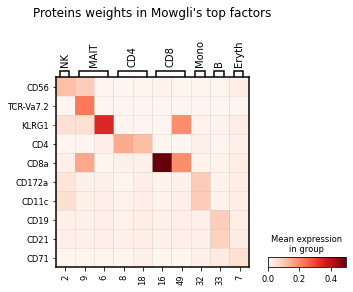

In [190]:
adata = ad.AnnData(H_mowgli["H_adt"])
adata.obs_names = mdata["adt"].var_names
adata.obs["adt"] = pd.Categorical(adata.obs_names)
adts = [
    "CD56",
    "TCR-Va7.2",
    "KLRG1",
    "CD4",
    "CD8a",
    "CD172a",
    "CD11c",
    "CD19",
    "CD21",
    "CD71",
]
adata = adata[
    adts,
    [2, 9, 6, 8, 18, 16, 49, 32, 33, 7],
]
varnames = {
    "NK": ["2"],
    "MAIT": ["9", "6"],
    "CD4": ["8", "18"],
    "CD8": ["16", "49"],
    "Mono": ["32"],
    "B": ["33"],
    "Eryth": ["7"],
    # " ": ["1", "3", "4", "5", "10", "11", "12", "13", "14", "15", "17", "19", "20", "21", "22", "23", "24", "25", "26", "27", "28", "29", "30", "31", "35", "36", "37", "38", "39", "40", "41", "42", "43", "44", "45", "46", "47", "48"],
}
sc.pl.matrixplot(
    adata,
    varnames,
    groupby="adt",
    cmap="Reds",
    categories_order=adts,
    title="Proteins weights in Mowgli's top factors",
    # standard_scale="group",
)


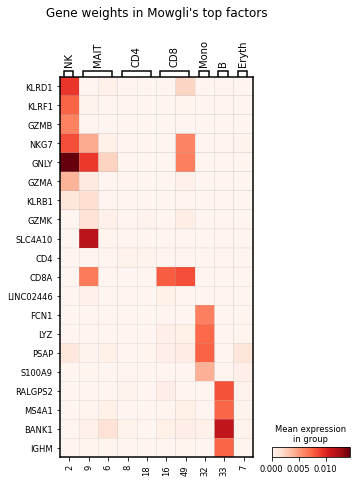

In [191]:
adata = ad.AnnData(H_mowgli["H_rna"])
adata.obs_names = mdata["rna"].var_names.str.replace("rna:", "")
adata.obs["rna"] = pd.Categorical(adata.obs_names)
genes = [
    "KLRD1",
    "KLRF1",
    "GZMB",
    "NKG7",
    "GNLY",
    "GZMA",
    "KLRB1",
    "GZMK",
    "SLC4A10",
    "CD4",
    "CD8A",
    "LINC02446",
    "FCN1",
    "LYZ",
    "PSAP",
    "S100A9",
    "RALGPS2",
    "MS4A1",
    "BANK1",
    "IGHM",
]
adata = adata[
    genes,
    [2, 9, 6, 8, 18, 16, 49, 32, 33, 7],
]
varnames = {
    "NK": ["2"],
    "MAIT": ["9", "6"],
    "CD4": ["8", "18"],
    "CD8": ["16", "49"],
    "Mono": ["32"],
    "B": ["33"],
    "Eryth": ["7"],
    # " ": ["1", "3", "4", "5", "10", "11", "12", "13", "14", "15", "17", "19", "20", "21", "22", "23", "24", "25", "26", "27", "28", "29", "30", "31", "35", "36", "37", "38", "39", "40", "41", "42", "43", "44", "45", "46", "47", "48"],
}
sc.pl.matrixplot(
    adata,
    varnames,
    groupby="rna",
    cmap="Reds",
    categories_order=genes,
    title="Gene weights in Mowgli's top factors",
    # standard_scale="group",
)


In [144]:
# celltypes = enr.loc[enr["source"] == "Azimuth_Cell_Types_2021", "native"].unique()

In [145]:
mowgli_pvals = ad.AnnData(np.zeros((len(celltypes), mowgli_embedding.n_vars)))
mowgli_pvals.obs_names = celltypes
mowgli_pvals.var_names = mowgli_embedding.var_names

for i, celltype in enumerate(celltypes):
    idx = enr["native"] == celltype
    idx &= enr["method"] == "mowgli"
    mowgli_pvals.X[i, enr.loc[idx, "dim"]] = enr.loc[idx, "minlogp"]
mowgli_pvals.obs["celltype"] = pd.Categorical(mowgli_pvals.obs_names)

In [146]:
mowgli_pvals.obs["celltype"].cat.categories = [
    "B gene set",
    "CD4 T gene set",
    "CD8 T gene set",
    "Mono gene set",
    "MAIT gene set",
    "NK gene set",
]


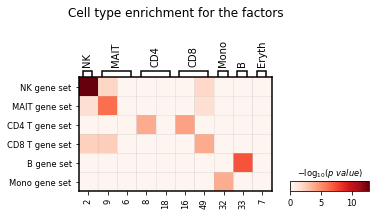

In [147]:
varnames = {
    "NK": ["2"],
    "MAIT": ["9", "6"],
    "CD4": ["8", "18"],
    "CD8": ["16", "49"],
    "Mono": ["32"],
    "B": ["33"],
    "Eryth": ["7"],
    # " ": ["1", "3", "4", "5", "10", "11", "12", "13", "14", "15", "17", "19", "20", "21", "22", "23", "24", "25", "26", "27", "28", "29", "30", "31", "35", "36", "37", "38", "39", "40", "41", "42", "43", "44", "45", "46", "47", "48"],
}
sc.pl.matrixplot(
    mowgli_pvals,
    varnames,
    groupby="celltype",
    categories_order=[
        "NK gene set",
        "MAIT gene set",
        "CD4 T gene set",
        "CD8 T gene set",
        "B gene set",
        "Mono gene set",
    ],
    cmap="Reds",
    title="Cell type enrichment for the factors",
    colorbar_title=r"$-\log_{10}(p~value)$",
)


In [148]:
# Pearson correlation.

idx = [2, 9, 6, 8, 18, 16, 49, 32, 33]

pval_matrix = mowgli_pvals[
    [
        "B Cell CL0000785",
        "Monocyte CL0000576",
        "Natural Killer CL0000623",
        "Mucosal Associated Invariant T CL0000940",
        "CD4 T CL0000624",
        "CD8 T CL0000625",
    ]
].X[:, idx]


mean_dim_matrix = np.vstack(
    [
        mowgli_embedding[mowgli_embedding.obs["leiden"] == "B cells"].X.mean(0),
        mowgli_embedding[mowgli_embedding.obs["leiden"] == "Monocytes"].X.mean(0),
        mowgli_embedding[mowgli_embedding.obs["leiden"] == "NK cells"].X.mean(0),
        mowgli_embedding[mowgli_embedding.obs["leiden"] == "MAIT T cells"].X.mean(0),
        mowgli_embedding[mowgli_embedding.obs["leiden"] == "CD4 T cells"].X.mean(0),
        mowgli_embedding[mowgli_embedding.obs["leiden"] == "CD8 T cells"].X.mean(0),
    ]
)[:, idx]

pearsonr(pval_matrix.ravel(), mean_dim_matrix.ravel())[0]


0.761180648814871

## Annotate MOFA

In [149]:
# Make an object for the MOFA embedding.
mofa_embedding = ad.AnnData(mdata.obsm["X_mofa"], obs=mdata.obs)
mofa_embedding.obs[mdata["adt"].var_names] = mdata["adt"].X

# Compute neighbors for mofa.
sc.pp.neighbors(mofa_embedding, n_neighbors=25)

# Compute UMAP for mofa
sc.tl.umap(mofa_embedding)

# Compute Leiden for mofa
sc.tl.leiden(mofa_embedding, resolution=0.2, key_added="leiden")

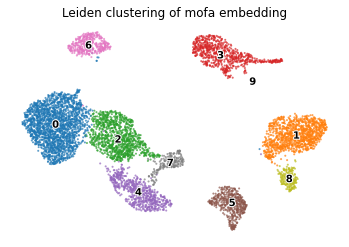

In [150]:
sc.pl.umap(
    mofa_embedding,
    color="leiden",
    alpha=0.7,
    legend_loc="on data",
    title="Leiden clustering of mofa embedding",
    legend_fontoutline=2,
    frameon=False,
)


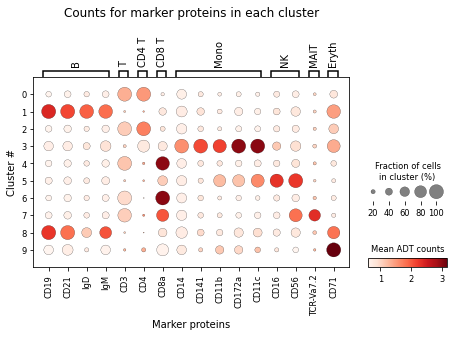

In [151]:
mdata["adt"].obs["leiden_mofa"] = mofa_embedding.obs["leiden"]
mdata["adt"].var_names = mdata["adt"].var_names.str.replace("adt:", "")
axes = sc.pl.dotplot(
    mdata["adt"],
    {
        "B": ["CD19", "CD21", "IgD", "IgM"],
        "T": "CD3",
        "CD4 T": "CD4",
        "CD8 T": "CD8a",
        "Mono": ["CD14", "CD141", "CD11b", "CD172a", "CD11c"],
        "NK": ["CD16", "CD56"],
        "MAIT": "TCR-Va7.2",
        "Eryth": "CD71",
    },
    groupby="leiden_mofa",
    title="Counts for marker proteins in each cluster",
    mean_only_expressed = True,
    colorbar_title = "Mean ADT counts",
    size_title = "Fraction of cells\nin cluster (%)",
    show=False,
    expression_cutoff=.5,
)
axes["mainplot_ax"].set_ylabel("Cluster #")
axes["mainplot_ax"].set_xlabel("Marker proteins")
plt.show()

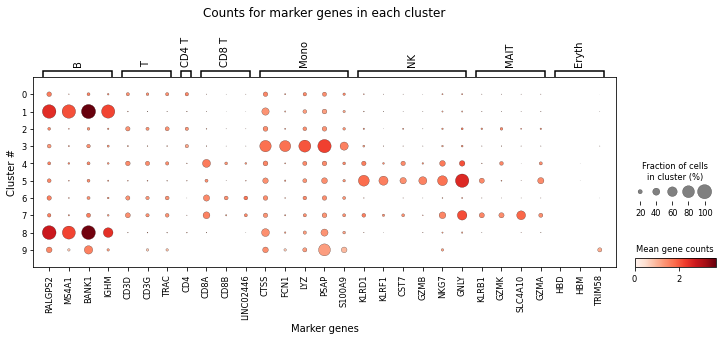

In [152]:
rna_all_genes.obs["leiden_mofa"] = mofa_embedding.obs["leiden"]
axes = sc.pl.dotplot(
    rna_all_genes,
    {
        "B": [gene for gene in ["RALGPS2", "MS4A1", "BANK1", "IGHM"] if gene in rna_all_genes.var_names],
        "T": [gene for gene in ["CD3D", "CD3G", "TRAC"] if gene in rna_all_genes.var_names],
        "CD4 T": [gene for gene in ["CD4"] if gene in rna_all_genes.var_names],
        "CD8 T": [gene for gene in ["CD8A", "CD8B", "LINC02446"] if gene in rna_all_genes.var_names],
        "Mono": [gene for gene in ["CTSS", "FCN1", "LYZ", "PSAP", "S100A9"] if gene in rna_all_genes.var_names],
        "NK": [gene for gene in ["KLRD1", "KLRF1", "CST7", "GZMB", "NKG7", "GNLY"] if gene in rna_all_genes.var_names],
        "MAIT": [gene for gene in ["KLRB1", "GZMK", "SLC4A10", "GZMA"] if gene in rna_all_genes.var_names],
        "Eryth": [gene for gene in ["HBD", "HBM", "TRIM58"] if gene in rna_all_genes.var_names],
    },
    groupby="leiden_mofa",
    title="Counts for marker genes in each cluster",
    mean_only_expressed=True,
    colorbar_title="Mean gene counts",
    size_title="Fraction of cells\nin cluster (%)",
    show=False,
)
axes["mainplot_ax"].set_ylabel("Cluster #")
axes["mainplot_ax"].set_xlabel("Marker genes")
plt.show()


In [153]:
# Annotate the mofa embedding.
cluster_names = {
    0: "CD4 T cells",
    1: "B cells",
    2: "CD4 T cells",
    3: "Monocytes",
    4: "CD8 T cells",
    5: "NK cells",
    6: "CD8 T cells",
    7: "MAIT T cells",
    8: "B cells",
    9: "Erythroid cells",
}
mofa_embedding.obs["leiden"] = [
    cluster_names[c] for c in mofa_embedding.obs["leiden"].cat.codes
]

/users/csb/huizing/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'leiden' as categorical


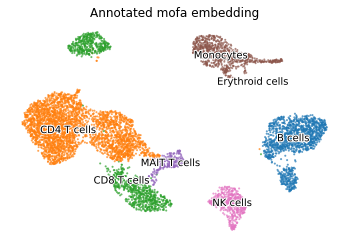

In [154]:
ax = sc.pl.umap(
    mofa_embedding,
    color="leiden",
    alpha=0.7,
    legend_loc="on data",
    title="Annotated mofa embedding",
    legend_fontoutline=2,
    frameon=False,
    legend_fontweight="normal",
    show=False,
)

## Interpret MOFA's dimensions

/users/csb/huizing/anaconda3/lib/python3.8/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)


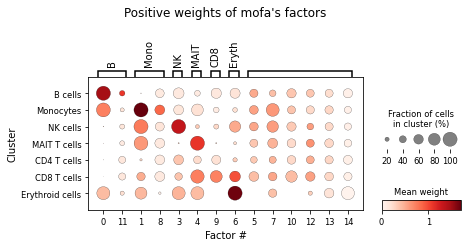

/users/csb/huizing/anaconda3/lib/python3.8/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)


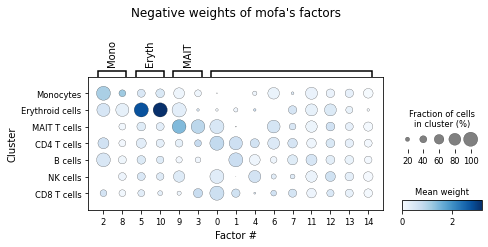

In [155]:
varnames = {
    "B": ["0", "11"],
    "Mono": ["1", "8"],
    "NK": ["3"],
    "MAIT": ["4"],
    "CD8": ["9"],
    "Eryth": ["6"],
    " ": ["5", "7", "10", "12", "13", "14"],
}
axes = sc.pl.dotplot(
    mofa_embedding,
    varnames,
    groupby="leiden",
    categories_order=[
        "B cells",
        "Monocytes",
        "NK cells",
        "MAIT T cells",
        "CD4 T cells",
        "CD8 T cells",
        "Erythroid cells",
    ],
    expression_cutoff=0,
    vmin=0,
    # vmax=5,
    log=True,
    mean_only_expressed=True,
    title="Positive weights of mofa's factors",
    colorbar_title = "Mean weight",
    size_title = "Fraction of cells\nin cluster (%)",
    show=False,
)
axes["mainplot_ax"].set_ylabel("Cluster")
axes["mainplot_ax"].set_xlabel("Factor #")
axes["mainplot_ax"].set_xticklabels(axes["mainplot_ax"].get_xticklabels(), rotation=0)
plt.show()

min_mofa_embedding = mofa_embedding.copy()
min_mofa_embedding.X = -min_mofa_embedding.X
varnames = {
    "Mono": ["2", "8"],
    "Eryth": ["5", "10"],
    "MAIT": ["9", "3"],
    " ": ["0", "1", "4", "6", "7", "11", "12", "13", "14"],
}
axes = sc.pl.dotplot(
    min_mofa_embedding,
    varnames,
    groupby="leiden",
    categories_order=[
        "Monocytes",
        "Erythroid cells",
        "MAIT T cells",
        "CD4 T cells",
        "B cells",
        "NK cells",
        "CD8 T cells",
    ],
    expression_cutoff=0,
    vmin=0,
    # vmax=5,
    log=True,
    mean_only_expressed=True,
    title="Negative weights of mofa's factors",
    colorbar_title = "Mean weight",
    size_title = "Fraction of cells\nin cluster (%)",
    show=False,
    cmap="Blues",
)
axes["mainplot_ax"].set_ylabel("Cluster")
axes["mainplot_ax"].set_xlabel("Factor #")
axes["mainplot_ax"].set_xticklabels(axes["mainplot_ax"].get_xticklabels(), rotation=0)
plt.show()


In [156]:
celltypes = [
    "Natural Killer CL0000623",
    "B Cell CL0000785",
    "Monocyte CL0000576",
    "CD4 T CL0000624",
    "CD8 T CL0000625",
    "Mucosal Associated Invariant T CL0000940",
]


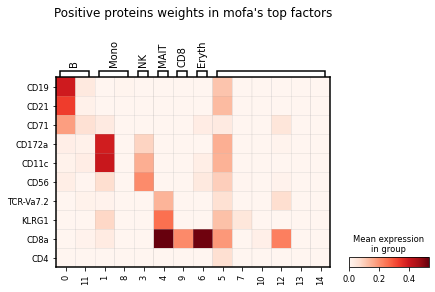

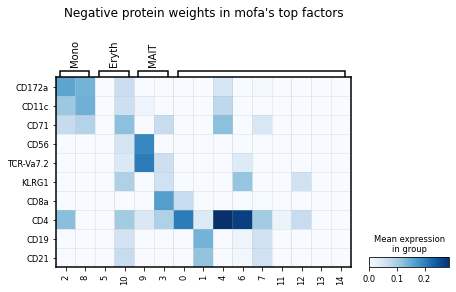

In [157]:
adata = ad.AnnData(H_mofa["H_adt"])
adata.X[adata.X < 0] = 0
adata.obs_names = mdata["adt"].var_names
adata.obs["adt"] = pd.Categorical(adata.obs_names)
adts = [
    "CD19",
    "CD21",
    "CD71",
    "CD172a",
    "CD11c",
    "CD56",
    "TCR-Va7.2",
    "KLRG1",
    "CD8a",
    "CD4",
]
adata = adata[
    adts,
    [0, 11, 1, 8, 3, 4, 9, 6, 5, 7, 10, 12, 13, 14],
]
varnames = {
    "B": ["0", "11"],
    "Mono": ["1", "8"],
    "NK": ["3"],
    "MAIT": ["4"],
    "CD8": ["9"],
    "Eryth": ["6"],
    " ": ["5", "7", "10", "12", "13", "14"],
}
sc.pl.matrixplot(
    adata,
    varnames,
    groupby="adt",
    cmap="Reds",
    categories_order=adts,
    title="Positive proteins weights in mofa's top factors",
    # standard_scale="group",
)

adata = ad.AnnData(H_mofa["H_adt"])
adata.X = -adata.X
adata.X[adata.X < 0] = 0
adata.obs_names = mdata["adt"].var_names
adata.obs["adt"] = pd.Categorical(adata.obs_names)
adts = [
    "CD172a",
    "CD11c",
    "CD71",
    "CD56",
    "TCR-Va7.2",
    "KLRG1",
    "CD8a",
    "CD4",
    "CD19",
    "CD21",
]
adata = adata[
    adts,
    [2, 8, 5, 10, 9, 3, 0, 1, 4, 6, 7, 11, 12, 13, 14],
]
varnames = {
    "Mono": ["2", "8"],
    "Eryth": ["5", "10"],
    "MAIT": ["9", "3"],
    " ": ["0", "1", "4", "6", "7", "11", "12", "13", "14"],
}
sc.pl.matrixplot(
    adata,
    varnames,
    groupby="adt",
    categories_order=adts,
    title="Negative protein weights in mofa's top factors",
    # standard_scale="group",
    cmap="Blues",
)


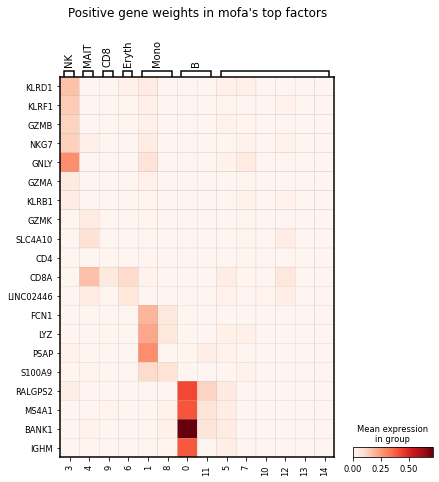

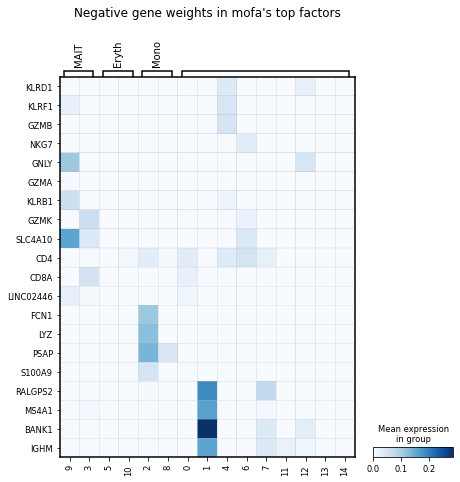

In [162]:
adata = ad.AnnData(H_mofa["H_rna"])
adata.X[adata.X < 0] = 0
adata.obs_names = mdata["rna"].var_names.str.replace("rna:", "")
adata.obs["rna"] = pd.Categorical(adata.obs_names)
genes = [
    "KLRD1",
    "KLRF1",
    "GZMB",
    "NKG7",
    "GNLY",
    "GZMA",
    "KLRB1",
    "GZMK",
    "SLC4A10",
    "CD4",
    "CD8A",
    "LINC02446",
    "FCN1",
    "LYZ",
    "PSAP",
    "S100A9",
    "RALGPS2",
    "MS4A1",
    "BANK1",
    "IGHM",
]
adata = adata[
    genes,
    [0, 11, 1, 8, 3, 4, 9, 6, 5, 7, 10, 12, 13, 14],
]
varnames = {
    "NK": ["3"],
    "MAIT": ["4"],
    "CD8": ["9"],
    "Eryth": ["6"],
    "Mono": ["1", "8"],
    "B": ["0", "11"],
    " ": ["5", "7", "10", "12", "13", "14"],
}
sc.pl.matrixplot(
    adata,
    varnames,
    groupby="rna",
    cmap="Reds",
    categories_order=genes,
    title="Positive gene weights in mofa's top factors",
    # standard_scale="group",
)


adata = ad.AnnData(H_mofa["H_rna"])
adata.X = -adata.X
adata.X[adata.X < 0] = 0
adata.obs_names = mdata["rna"].var_names.str.replace("rna:", "")
adata.obs["rna"] = pd.Categorical(adata.obs_names)
genes = [
    "KLRD1",
    "KLRF1",
    "GZMB",
    "NKG7",
    "GNLY",
    "GZMA",
    "KLRB1",
    "GZMK",
    "SLC4A10",
    "CD4",
    "CD8A",
    "LINC02446",
    "FCN1",
    "LYZ",
    "PSAP",
    "S100A9",
    "RALGPS2",
    "MS4A1",
    "BANK1",
    "IGHM",
]
adata = adata[
    genes,
    [2, 8, 5, 10, 9, 3, 0, 1, 4, 6, 7, 11, 12, 13, 14],
]
varnames = {
    "MAIT": ["9", "3"],
    "Eryth": ["5", "10"],
    "Mono": ["2", "8"],
    " ": ["0", "1", "4", "6", "7", "11", "12", "13", "14"],
}
sc.pl.matrixplot(
    adata,
    varnames,
    groupby="rna",
    cmap="Blues",
    categories_order=genes,
    title="Negative gene weights in mofa's top factors",
    # standard_scale="group",
)


In [163]:
# celltypes = enr.loc[enr["source"] == "Azimuth_Cell_Types_2021", "native"].unique()

In [176]:
mofa_top_pvals = ad.AnnData(np.zeros((len(celltypes), mofa_embedding.n_vars)))
mofa_top_pvals.obs_names = celltypes
mofa_top_pvals.var_names = mofa_embedding.var_names

for i, celltype in enumerate(celltypes):
    idx = enr["native"] == celltype
    idx &= enr["query"].str.startswith("top_mofa")
    mofa_top_pvals.X[i, enr.loc[idx, "dim"]] = enr.loc[idx, "minlogp"]
mofa_top_pvals.obs["celltype"] = pd.Categorical(mofa_top_pvals.obs_names)

mofa_bottom_pvals = ad.AnnData(np.zeros((len(celltypes), mofa_embedding.n_vars)))
mofa_bottom_pvals.obs_names = celltypes
mofa_bottom_pvals.var_names = mofa_embedding.var_names

for i, celltype in enumerate(celltypes):
    idx = enr["native"] == celltype
    idx &= enr["query"].str.startswith("bottom_mofa")
    mofa_bottom_pvals.X[i, enr.loc[idx, "dim"]] = enr.loc[idx, "minlogp"]
mofa_bottom_pvals.obs["celltype"] = pd.Categorical(mofa_bottom_pvals.obs_names)

In [177]:
mofa_top_pvals.obs["celltype"].cat.categories = [
    "B gene set",
    "CD4 T gene set",
    "CD8 T gene set",
    "Mono gene set",
    "MAIT gene set",
    "NK gene set",
]

mofa_bottom_pvals.obs["celltype"].cat.categories = [
    "B gene set",
    "CD4 T gene set",
    "CD8 T gene set",
    "Mono gene set",
    "MAIT gene set",
    "NK gene set",
]


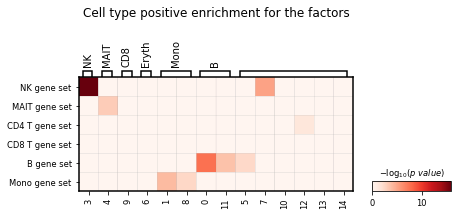

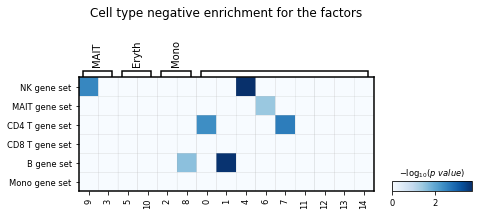

In [179]:
varnames = {
    "NK": ["3"],
    "MAIT": ["4"],
    "CD8": ["9"],
    "Eryth": ["6"],
    "Mono": ["1", "8"],
    "B": ["0", "11"],
    " ": ["5", "7", "10", "12", "13", "14"],
}
sc.pl.matrixplot(
    mofa_top_pvals,
    varnames,
    groupby="celltype",
    categories_order=[
        "NK gene set",
        "MAIT gene set",
        "CD4 T gene set",
        "CD8 T gene set",
        "B gene set",
        "Mono gene set",
    ],
    cmap="Reds",
    title="Cell type positive enrichment for the factors",
    colorbar_title=r"$-\log_{10}(p~value)$",
)

varnames = {
    "MAIT": ["9", "3"],
    "Eryth": ["5", "10"],
    "Mono": ["2", "8"],
    " ": ["0", "1", "4", "6", "7", "11", "12", "13", "14"],
}
sc.pl.matrixplot(
    mofa_bottom_pvals,
    varnames,
    groupby="celltype",
    categories_order=[
        "NK gene set",
        "MAIT gene set",
        "CD4 T gene set",
        "CD8 T gene set",
        "B gene set",
        "Mono gene set",
    ],
    cmap="Blues",
    title="Cell type negative enrichment for the factors",
    colorbar_title=r"$-\log_{10}(p~value)$",
)
